# Function Definitions

In [117]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from sklearn.preprocessing import normalize
from functools import partial

%matplotlib inline

#target = -1 + 2*x1 + 2*x2 #np.array([2,2,-1])
df = pd.DataFrame({'x1':[0,1,0,-0.5,-1,2,1,3,0.5,-1,0,-2,-3,1,2,-4,-3,3,-0.5,-2],
                   'x2':[0,1,1,0,-1,4,-1,-5,-2,1,3,0,-1,6,8,2,3,10,2,1], 
                   'y':[1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]})
df['x0'] = 1
df = df[['x0','x1', 'x2', 'y']]

def perceptron(points, dim, max_it=100, use_adaline=False, 
               eta = 1, randomize=False, print_out = True,
               max_updates = None):
    w = np.zeros(dim+1)
    xs, ys = points[:,:dim+1], points[:,dim+1]
    num_points = points.shape[0]
    updates = 0
    for it in range(max_it):
        correctly_predicted_ids=  set()
        idxs = np.arange(num_points)
        if randomize:
            idxs = np.random.choice(np.arange(num_points), num_points, replace=False)
        for idx in idxs:
            x, y = xs[idx], ys[idx]
            st = np.dot(w.T, x)
            prod = st*y #np.dot(w.T, x)*y
            if prod < -100: #avoid out of bound error
                st = -100
            threshold = 1 if use_adaline else 0
            st = st if use_adaline else 0
            if prod <= threshold:
                w = w + eta *(y-st)*x
                updates += 1
            else:
                correctly_predicted_ids.add(idx)
        if len(correctly_predicted_ids) == num_points:
            break
        if max_updates is not None and updates >= max_updates:
            break
    
    c = 0
    for x, y in zip(xs, ys):
        prod = np.dot(w.T, x)*y
        if prod > 0:
            c +=1
    w = w/w[-1]
    if print_out:
        print('final correctness: ', c, '. Total iteration: ', it)
        print('final normalized w:', w)
    return w, it
    
def flip_coins(total_coins):
    """Flip all coins once, return their head/tail status
    """
    
    hts = np.zeros(total_coins) #head: 1, tail: 0
    probs = np.random.uniform(size=total_coins)
    hts[probs > 0.5] = 1
    return hts

def run_once(total_coins, total_flips, print_freq = False):
    v1, vrand, vmin = None, None, None
    crand = np.random.choice(total_coins)
    hts_sum = np.zeros(total_coins) # store the sum of heads in total_flips
    
    for flip in range(total_flips):
        hts_sum = hts_sum + flip_coins(total_coins)
    
    hts_freq = hts_sum/total_flips
    
    v1 = hts_freq[0]
    vrand = hts_freq[crand]
    cmin = np.argmin(hts_sum)
    vmin = hts_freq[cmin]
    
    if print_freq:
        print('Frequency of first coin: {}'.format(v1))
        print('Frequency of a random coin: id({})-freq({})'.format(crand, vrand))
        print('Frequency of the coin with minimum frequency: id({})-freq({})'.format(cmin, vmin))
    return v1,vrand,vmin

def hoeffding_bound(epsilon, n):
    return 2.0*np.exp(-2.0*n*epsilon**2)


def generate_random_numbers01(N, dim, num_grid_points):
    random_ints = np.random.randint(num_grid_points, size=(N, dim))
    init_lb = 0
    return (random_ints - init_lb)/(num_grid_points - 1 - init_lb)

def generate_random_numbers(N, dim, num_grid_points, lb, ub):
    zero_to_one_points = generate_random_numbers01(N, dim, num_grid_points)
    res = lb + (ub - lb)*zero_to_one_points
    return res

def generate_random_coeffs(dim):
    rn = generate_random_numbers(1, dim, 1000, -10, 10)
    return rn

def true_f(x, coeffs):
    return coeffs.flatten()[0] + np.dot(coeffs.flatten()[1:], x.flatten())

def generate_two_classes(N, dim, true_func, rn_func):
    cls1, cls2 = [], []
    while True:
        rn = rn_func(1, dim).flatten()
        if true_func(rn) > 0 and len(cls1) < N:
            cls1.append(rn)
        elif true_func(rn) < 0 and len(cls2) < N:
            cls2.append(rn)
        if len(cls1) == N and len(cls2) == N:
            break
    return np.asarray(cls1), np.asarray(cls2)    

def generate_df(N, dim,true_func, rn_func):
    cls1, cls2 = generate_two_classes(N/2, dim, true_func, rn_func)
    cols = ['x' + str(i) for i in range(1, dim+1)]
    df1 = pd.DataFrame(cls1, columns=cols)
    df1['y'] = 1
    df2 = pd.DataFrame(cls2, columns=cols)
    df2['y'] = -1
    df = pd.concat([df1, df2])
    df['x0'] = 1
    df = df[['x0'] + cols + ['y']]
    return df

def run_perceptron_experiment(N, dim, lb, ub, num_random_numbers, num_grid_points,
                             coeff_lb, coeff_ub, eta, maxit, use_adaline=False, randomize=False,
                             show_plot=True, max_updates = None, test_N = 10000):
    
    rns = generate_random_numbers(N, dim, num_grid_points, lb, ub)
    rn_func = partial(generate_random_numbers, num_grid_points = num_grid_points, lb = lb, ub = ub)
    coeffs = generate_random_numbers(1, dim+1, num_random_numbers, coeff_lb, coeff_ub)
    norm_coeffs = coeffs.flatten()/coeffs.flatten()[-1]
    true_func = partial(true_f, coeffs = norm_coeffs)
    
    df = generate_df(N, dim, true_func, rn_func)
    test_df = generate_df(test_N, dim, true_func, rn_func)
    
    x1 = np.arange(lb, ub, 0.01)
    norm_g, num_its = perceptron(df.values, dim, maxit, use_adaline, 
                                 eta, randomize, show_plot, max_updates)
    
    if show_plot:
        print('True coeffs: ', norm_coeffs)
        figsize = plt.figaspect(1)
        f, ax = plt.subplots(1, 1, figsize=figsize)
        cls1_df = df.loc[df['y']==1]
        cls2_df = df.loc[df['y']==-1]
        line = ax.plot(x1, -(norm_coeffs[0]+norm_coeffs[1]*x1), label='True Function')
        pluses = ax.scatter(cls1_df[['x1']].values, cls1_df[['x2']].values, marker='+', c= 'r', label='+1 labels')
        minuses = ax.scatter(cls2_df[['x1']].values, cls2_df[['x2']].values, marker=r'$-$', c= 'b', label='-1 labels')
        hypothesis = ax.plot(x1, -(norm_g[0]+norm_g[1]*x1), c = 'r', label='Final Hypothesis')

        ax.set_ylabel(r"$x_2$", fontsize=11)
        ax.set_xlabel(r"$x_1$", fontsize=11)
        ax.set_title('Training set size = %s'%len(cls1), fontsize=9)
        ax.axis('tight')
        legend_x = 2.0
        legend_y = 0.5
        ax.legend(['True Function', 'Final Hypothesis', 
                   '+1 labels', '-1 labels', ], 
                  loc='center right', bbox_to_anchor=(legend_x, legend_y))
        #ax.legend(handles=[pluses, minuses], fontsize=9)
        ax.set_ylim(bottom=lb, top=ub)
        plt.show()
    return num_its, norm_g, test_df

# Chapter 1 The Learning Problem

## Exercises

#### Exercise 1.1

1. (a) 
  * Input space $\mathcal{X}$: patient's medical history, symptoms, personal health information etc.
  * Output space $\mathcal{Y}$: all possible diseases
  * target function $f: \mathcal{X} \to \mathcal{Y}$: ideal formula to identify a patient's problem
  * Data set: All available patients' information and their corresponding correct problem diagnostic.
2. (b)
  * Input space $\mathcal{X}$: handwritten digits (digitalized)
  * Output space $\mathcal{Y}$: 0-9 digits
  * target function $f: \mathcal{X} \to \mathcal{Y}$: ideal formula match a handwritten digit to a correct digit
  * Data set: handwritten digits and their corresponding correct matches
3. (c)
  * Input space $\mathcal{X}$: every information of an email, e.g. words
  * Output space $\mathcal{Y}$: yes/no 
  * target function $f: \mathcal{X} \to \mathcal{Y}$: ideal formula to identify whether an email is spam or not
  * Data set: Spam and non-spam emails that have been identified by human
4. (d)
  * Input space $\mathcal{X}$: price of electric, temperature, day of the week
  * Output space $\mathcal{Y}$: electric load
  * target function $f: \mathcal{X} \to \mathcal{Y}$: ideal function that gives exact electric load for a given price, temperature and day of the week.
  * Data set: historical electric load along with corresponding price, temperature and day of the week information.
5. (e) 
  * Input space $\mathcal{X}$: cat images 
  * Output space $\mathcal{Y}$: types of cats
  * target function $f: \mathcal{X} \to \mathcal{Y}$: ideal function that gives cat type according to the picture
  * Data set: picutres with cats that have been categorized to various types

#### Exercise 1.2
1. (a) Keywords with a large positive weight: free, cheap, earn, !
1. (b) Keywords with a negative weight: person name, hi, the
1. (c) The parameter $b$ in perceptron directly affects how many borderline messages end up being classified as spam. This is because $b$ is the threshold used to classify the emails into spam and non-spam categories.

#### Exercise 1.3
1. (a) If $x(t)$ is misclassified by $w(t)$, then $w^T(t)x(t)$ has different signs of $y(t)$, thus $y(t)w^T(t)x(t) \gt 0$.
2. (b) 
\begin{align}
y(t)w^T(t+1)x(t)  &= y(t) \left(w(t)+y(t)x(t)\right)^Tx(t) \\
&= y(t)\left(w^T(t) + y(t)x^T(t)\right)x(t) \\
&= y(t)w^T(t)x(t) + y(t)y(t)x^T(t)x(t)\\
&\gt y(t)w^T(t)x(t) \;\;\;\text{because the last term is } \ge \text{ than } 0\\
\end{align}
3. (c) 

From previous problem, we see that $y(t)w^T(t)x(t)$ is increasing with each update. 

If $y(t)$ is positive, but $w^T(t)x(t)$ is negative, we move $w^T(t)x(t)$ toward positive by increasing it. 

If however $y(t)$ is negative, but $w^T(t)x(t)$ is positive, $y(t)w^T(t)x(t)$ increases means $w^T(t)x(t)$ is decreasing, i.e. moving toward negative region. 

So the move from $w(t)$ to $w(t+1)$ is a move "in the right direction" as far as classifying $x(t)$ is concerned.

#### Exercise 1.4
Implement the perceptron learning algorithm and check
* Convergence speed: The convergence is fast, it only takes 1 iterations to find a solution.
* How well the final hypothesis $g$ matches your target $f$: The final hypothesis $g$ doesn't match my target $f$ very closely in terms of their coefficients. But from picture, they are largely in line with each other in the range of data.

final correctness:  20 . Total iteration:  4
final normalized w: [ 0.04765828 -0.45960265  1.        ]
True coeffs:  [ 0.41374046 -0.52977099  1.        ]


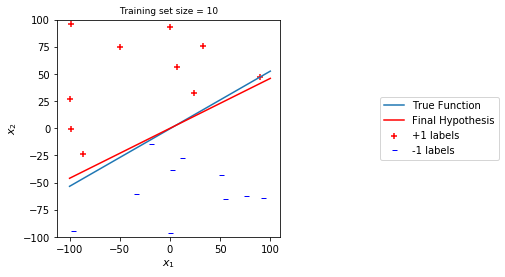

In [118]:
#perceptron(df.values, 2)

lb, ub = -100, 100
N, dim = 20, 2 
num_random_numbers, num_grid_points = 1000, 2000
coeff_lb, coeff_ub = -10, 10
eta = 1
maxit = 100
use_adaline, randomize =False, False
_, _, _ = run_perceptron_experiment(N, dim, lb, ub, num_random_numbers, num_grid_points,
                             coeff_lb, coeff_ub, eta, maxit, use_adaline, randomize)

#### Exercise 1.5
1. (a) Learning
1. (b) Design
1. (c) Learning
1. (d) Design
1. (e) Learning

#### Exercise 1.6
1. (a) Supervised Learning
1. (b) Reinforcement Learning
1. (c) Unsupervised Learning
1. (d) Learning to play music
  * If learn by yourself, it's unsupervised learning
  * If learn from a teacher, it's supervised learning
  * If learn by yourself but with someone to tell you if your music is good or not, it's reinforcement learning. 
1. (e) Supervised Learning

#### Exercise 1.7
1. (a) The learning algorithm will pick the final hypothesis that always returns 1. 
  * 1 out of 8 $f$ agrees with $g$ on all three points; 3 $f$ agree with $g$ on two of the points; 3 $f$ agree with $g$ on one of the points, 1 $f$ agrees with none of the points. 
1. (b) The learning algorithm will pick the final hypothesis that always returns 0. 
  * 1 out of 8 $f$ agrees with $g$ on all three points; 3 $f$ agree with $g$ on two of the points; 3 $f$ agree with $g$ on one of the points, 1 $f$ agrees with none of the points.
1. (c) The learning algorithm will pick the final hypothesis $XOR$. 
  * 1 out of 8 $f$ agrees with $g$ on all three points; 3 $f$ agree with $g$ on two of the points; 3 $f$ agree with $g$ on one of the points, 1 $f$ agrees with none of the points.
1. (d) The learning algorithm will pick the final hypothesis $f_7$. 
  * 1 out of 8 $f$ agrees with $g$ on all three points; 3 $f$ agree with $g$ on two of the points; 3 $f$ agree with $g$ on one of the points, 1 $f$ agrees with none of the points.
  
#### Exercise 1.8

In a sample of 10 marbles, for the fraction $\nu$ of red marbles to be $\nu \le 0.1$, we must have at most one red marbles. 

\begin{align}
P(number\;of\;red \le 1) &= P(red = 0) + P(red = 1) \\
&= (1-\mu)^{10} + \mu (1-\mu)^9\\
&= (1-\mu)^9\\
&= 1.0e-9
\end{align}

#### Exercise 1.9
We have $\mu=0.9$, $N=10$, and want $\nu \le 0.1$, i.e. $|\mu - \nu| = \mu - \nu \ge 0.9 - 0.1 = 0.8$. Let's pick $\epsilon = 0.7$, then according to Hoeffding Inequity, we have

\begin{align}
P(\nu \le 0.1) &= P(\mu - \nu \ge 0.8)\\
&= P(|\mu - \nu| \ge 0.8) \\
&\le P(|\mu - \nu| \gt 0.7) \\
&= P(|\mu - \nu| \gt \epsilon) \\
&\le 2e^{-2\epsilon^2N}\\
&\approx 0.0001109032
\end{align}

This is an upper bound of the probability from pervious problem and is much larger than the calculated probability.


#### Exercise 1.10
1. (a) The $\mu$ for the three coins are all $0.5$ since the coins are fair.

In [70]:
# Exercise 1.10 (a) 
total_coins = 1000
total_flips = 10
run_once(total_coins, total_flips, True)

Frequency of first coin: 0.5
Frequency of a random coin: id(83)-freq(0.3)
Frequency of the coin with minimum frequency: id(7)-freq(0.0)


(0.5, 0.3, 0.0)

(array([6.23941e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        3.76049e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 <a list of 10 Patch objects>)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


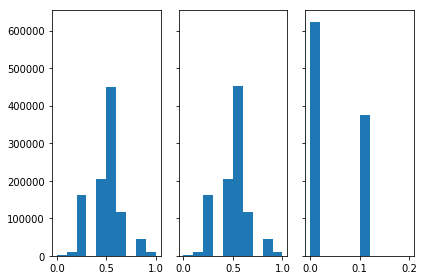

In [56]:
# Exercise 1.10 (b) 
total_coins = 1000
total_flips = 10
total_runs = 1000000
v1s, vrands, vmins = [],[],[]
for run in range(total_runs):
    v1,vrand,vmin = run_once(total_coins, total_flips)
    v1s.append(v1)
    vrands.append(vrand)
    vmins.append(vmin)

fig, axs = plt.subplots(1,3,sharey=True, tight_layout=True)
n_bins = 10
axs[0].hist(v1s,bins=n_bins)
axs[1].hist(vrands,bins=n_bins)
axs[2].hist(vmins,bins=n_bins)

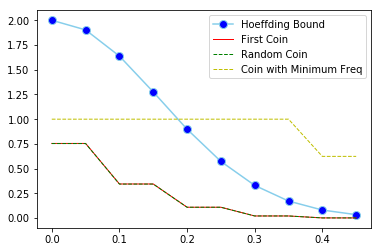

In [65]:
# Exercise 1.10 (c)
eps = np.arange(0.0,0.5,0.05)
bounds = hoeffding_bound(eps, total_flips)
v1s, vrands, vmins = np.array(v1s), np.array(vrands), np.array(vmins)
v1d = np.abs(v1s-0.5)
vrandd = np.abs(vrands-0.5)
vmind = np.abs(vmins-0.5)

p1, prand, pmin = np.zeros(len(eps)),np.zeros(len(eps)),np.zeros(len(eps))

for idx in range(eps.shape[0]):
    ep = eps[idx]
    p1[idx] = np.sum(v1d > ep)/total_runs
    prand[idx] = np.sum(vrandd > ep)/total_runs
    pmin[idx] = np.sum(vmind > ep)/total_runs

#plt.ylim((0,0.01))    
plt.plot(eps, bounds, marker='o', markerfacecolor='blue', markersize=8, color='skyblue', label='Hoeffding Bound')
plt.plot(eps, p1, marker='', color='r', linewidth=1, label='First Coin')
plt.plot(eps, prand, marker='', color='g', linewidth=1, linestyle='dashed', label='Random Coin')
plt.plot(eps, pmin, marker='', color='y', linewidth=1, linestyle='dashed', label='Coin with Minimum Freq')
plt.legend()

#### Exercise 1.10
1. (d) The first and random coins follow the Hoeffding bound. The coin with minimum frequency doesn't obey Hoeffding bound. This is because that for the first two coins, the coins were chosen before the experiment. While for the last one, we have to flip all the coins first, and use the data to compute out which is the coin with minimum frequency of heads. This violates the Hoeffding inequality condition which says the hypothesis $h$ has been fixed before samples were drawn.

1. (e) When we choose the coin having the minimum frequency of heads. We are like choosing the bin from 1000 bins (our hypothesis space). But we choose bin after we finish sampling the data.  This is akin to learning algorithm for the final hypothesis. The other two coins were chosen before the sampling, which is choosing bin beforehand.

#### Exercise 1.11

1. (a) $S$ can not produce a hypothesis that is guaranteed to perform better than random on any point outside $\mathcal{D}$. 
If $f$ has 25 $+1$ on $\mathcal{D}$ but $-1$ on all other points in $\mathcal{X}$, $S$ will choose the hypothesis $h_1$, which will not match $f$ outside of $\mathcal{D}$ at all. On the other hand, a random function will have $+1$ and $-1$ 50/50, and it matches $f$ half of time, which is better than the function produced by $S$.

1. (b) It is possible that $C$ produces a better hypothesis than $S$ produces. See the example above.
1. (c) If every point in $\mathcal{D}$ has 1, then $S$ will choose $h_1$ and $C$ will choose $h_2$. So outside of $\mathcal{D}$, $h_1$ will have 90% chance to match with $f$, while $h_2$ will have only 10% chance. $S$ will always produce a better hypothesis than $C$. 

1. (d) From previous problem, we can see that when $p \lt 0.5$, $C$ will produce a better hypothesis than $S$. Since $C$ always produce $h_2$, which will match $f$ better than $h_1$ if $p \lt 0.5$.

#### Exercise 1.12

I think the best I can promise is (c). 
* The unknown target $f$ can be very complex that we can't learn at all.
* If we can learn and produce a hypothesis $g$, since there are many data points (4000), the probability that $g$ matches $f$ is high according to Hoeffding inequality, and the error on $g$ might be small since we have a large data set.

#### Exercise 1.13

1. (a) The probability of error that $h$ makes in approximating $y$ is

\begin{align}
P(h \ne y) &= P(h \ne y| y = f(x))P(y=f(x)) + P(h\ne y| y \ne f(x))P(y\ne f(x))\\
&= \mu \lambda + (1-\mu)(1-\lambda)\\
&= \mu (2 \lambda - 1) + (1-\lambda)\\
\end{align}

1. (b) It can be seen from previous problem, that when $\lambda = 0.5$, $P(h\ne y) = 1-\lambda = 0.5$, is independent of $\mu$.

## Problems

#### Problem 1.1

\begin{align}
P(1st \;ball \;is\; black) &= P(1st\; ball\; is\; black|picked\; black,black\; bag)P(picked\; black,black\; bag) + P(1st\; ball\; is\; black|picked\; black,white\; bag)P(picked\; black,white\; bag)\\
&= 1.0*0.5 + 0.5 * 0.5\\
&= 0.75\\
\end{align}

\begin{align}
P(picked\;black,black \;bag|1st\; ball\; is\; black) &= \frac{P(picked\; black,black\; bag\; and\; 1st\; ball\; is\; black)}{P(1st\; ball\; is\; black)} \\
&= \frac{P(1st\; ball\; is\; black|picked\; black,black\; bag)P(picked\; black,black\; bag)}{P(1st \;ball \;is\; black)}\\
&= \frac{1.0*0.5}{0.75}\\
&= \frac{2}{3}\\
\end{align}

\begin{align}
P(picked\;black,white \;bag|1st\; ball\; is\; black) &= \frac{1}{3}\\
\end{align}

Now we can compute the probability that the second ball is also black:

\begin{align}
P(2nd\; ball\; is \;black) &= P(2nd\; ball\; is\; black|picked\;black,black \;bag|1st\; ball\; is\; black)*P(picked\;black,black \;bag|1st\; ball\; is\; black) + P(2nd\; ball\; is \;black|picked\;black,white \;bag|1st\; ball\; is\; black)*P(picked\;black,white \;bag|1st\; ball\; is\; black)\\
&= 1.0*\frac{2}{3} + 0*\frac{1}{3}\\
&= \frac{2}{3}
\end{align}

#### Problem 1.2

1. (a)

for $h(x) =1$, we need to have $w^Tx \gt 0$, and for $h(x) = -1$, we need to have $w^Tx \lt 0$. The line separate the two regions has $w^Tx = w_0 + w_1 x_1 + w_2 x_2 = 0$, compare with $x_2 = ax_1 + b$, we have $ a = -\frac{w_1}{w_2}$ and $b =  -\frac{w_0}{w_2}$.

1. (b) The pictures for the cases $w=[1,2,3]^T$ and $w=-[1,2,3]^T$ should be be same according to the formula above.

#### Problem 1.3


1. (a) If $w^{*}$ is the optimal set of weights that separate the data, then for every $x_n$ in the data set $\mathcal{D}$, $w^{*T}x_n$ has the same sign as $y_n$, which means $y_n(w^{*T}x_n) \gt 0$. This implies $\rho = min_{1\le n\le N}y_n(w^{*T}x_n) \gt 0$.


1. (a) Let's use induction to prove this.
  * When $t=1$, we have $w^T(t-1)w^* + \rho = w^T(0)w^* + \rho = \rho$, while $w(t)=w(1) = w(0) + y_ix_i = y_ix_i$ for some $i$. 
  
  So $w^T(t)w^* = (y_ix_i)^Tw^* = y_ix_i^Tw^* = y_iw^{*T}x_i$. Here we use the fact that $y_i \in {-1,1}$ and $x_i^Tw^*$ is a scalar. By definition of $\rho$, we have $y_iw^{*T}x_i \ge \rho$. Thus the inequation is valid at $t=1$.
  
  
  * Suppose the inequation is valid at $t$, let's prove that it's still valid at $t+1$. 
  $w(t+1)=w(t)+y_ix_i$ for som e $i$. Then
  
  \begin{align}
  w^T (t+1)w^* &= w^T(t)w^* + y_ix_i^Tw^* \\
  &\ge w^T(t-1)w^* + \rho + y_ix_i^Tw^*  \\
  &= \left(w^T(t-1) + y_ix_i^T\right)w^* + \rho \\
  &= w^T(t)w^* + \rho
  \end{align}
  
  This finishes the proof.
  
  It's easy to see that $w^T(t)w^* \ge w^T(t-1)w^* + \rho \ge w^T(t-2)w^* + 2\rho \ge \dots \ge t\rho$.
  
  
1. (c) $w(t) = w(t-1) + y(t-1)x(t-1)$, take squared norm on $w(t)$ we have 

\begin{align}
||w(t)||^2 &= \left(w(t-1) + y(t-1)x(t-1)\right)^T\left(w(t-1) + y(t-1)x(t-1)\right)\\
&= ||w(t-1)||^2 + ||y(t-1)||^2||x(t-1)||^2 + 2y(t-1)w^T(t-1)x(t-1) \\
&= ||w(t-1)||^2 + ||x(t-1)||^2 + 2y(t-1)w^T(t-1)x(t-1) \\
&\le ||w(t-1)||^2 + ||x(t-1)||^2
\end{align}

since $y(t-1)w^T(t-1)x(t-1) \le 0$ because $x(t-1)$ was misclassified by $w(t-1)$.

1. (d) Let's use induction.
  * When $t=0$, it's obvious that $||w(0)||^2 = 0 \le tR^2 = 0$.
  * Assume at $t$, we have $||w(t)||^2 \le tR^2$, then at $t+1$, we have $||w(t)||^2 \le ||w(t-1)||^2 + ||x(t-1)||^2 $ from previous problem. Then we have
  
  $||w(t)||^2 \le ||w(t-1)||^2 + ||x(t-1)||^2 \le (t-1)R^2 + R^2 = tR^2$ 
  
  where we used the fact that $||x(t-1)||^2 \le R^2$ by definition of $R$.
  
1. (e) Apply the results from (b) and (d) we have 

$\frac{w^T(t)}{||w(t)||} w^* \ge \frac{t\rho}{||w(t)||} \ge  \frac{t\rho}{\sqrt{t}R} = \sqrt{t}\frac{\rho}{R}$.


Reverse the inequality and square, we have 

\begin{align}
t &\le \frac{R^2}{\rho^2} \frac{\left(w^T(t)w^*\right)^T\left(w^T(t)w^*\right)}{||w(t)||^2} \\
&= \frac{R^2}{\rho^2} \frac{w^{*T}w(t)w^T(t)w^*}{||w(t)||^2} \\
&= \frac{R^2}{\rho^2} ||w^*||^2
\end{align}

Or we can use the hint, where 
$\frac{w^{*T}w^*}{||w(t)||||w^*||} \le 1$ because $||w^T(t)w^*|| \le ||w^T(t)||\cdot||w^*||$ 

according to the Cauchy-Schwarz inequality. Then we have 

$\sqrt{t}\frac{\rho}{R} \le \frac{w^{*T}w^*}{||w(t)||} \le ||w^*||$

Move $t$ to the right and square, we obtain the desired inequality.

#### Problem 1.4

1. (a) See plot below
1. (b) It takes a couple of iterations to find a line that can separate the data, very fast. But the final hypothesis $g$ is not necessarily close the target functio $f$.
1. (c) Repeat the experiment in (b) shows similar results
1. (d) When $N=100$, the PLA still finds a solution fast in a couple of iterations
1. (e) $N=1000$, it now takes more about 100 iterations to find a solution
1. (f) $N=1000$ and $d=10$, it takes about 500 iterations to find a solution, sometimes it can take 2000 iterations. 
1. (g)
1. (h) As $N$ or $d$ increases, it takes more time to find a solution. As long as the data are separable, it can always find a solution. 

final correctness:  20 . Total iteration:  2
final normalized w: [-0.0653268  -2.35294118  1.        ]
True coeffs:  [ 1.64 -2.36  1.  ]


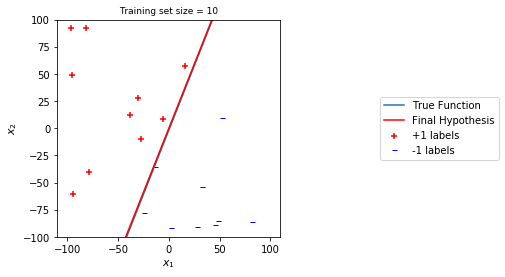

In [115]:
#### problem 1.4 (a)-(c)
lb, ub = -100, 100
N, dim = 20, 2 
num_random_numbers, num_grid_points = 1000, 2000
coeff_lb, coeff_ub = -10, 10
eta = 1
maxit = 100
use_adaline, randomize =False, False
_, _, _ = run_perceptron_experiment(N, dim, lb, ub, num_random_numbers, num_grid_points,
                             coeff_lb, coeff_ub, eta, maxit, use_adaline, randomize)

True coeffs:  [ 0.68331303 -0.26918392  1.        ]
final correctness:  1000 . Total iteration:  295
final normalized w: [ 0.38977716 -0.27086109  1.        ]


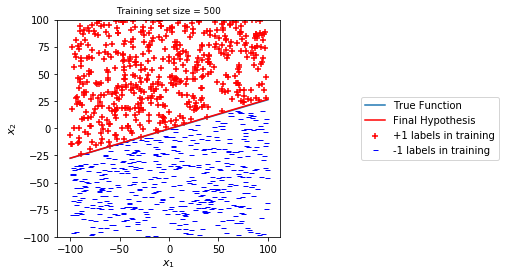

In [69]:
#### problem 1.4 (d)(e)
lb, ub = -100, 100
N, dim = 1000, 2 
num_random_numbers, num_grid_points = 1000, 2000
coeff_lb, coeff_ub = -10, 10
eta = 1
maxit = 2000
use_adaline, randomize =False, False
run_perceptron_experiment(N, dim, lb, ub, num_random_numbers, num_grid_points,
                             coeff_lb, coeff_ub, eta, maxit, use_adaline, randomize)

True coeffs:  [ 0.5041876   0.85929648 -1.59966499  1.01675042 -0.5041876   0.73534338
  1.03350084 -0.76214405 -1.27135678 -0.92964824  1.        ]
final correctness:  993 . Total iteration:  1999
final normalized w: [ 0.30943109  0.88211462 -1.62488141  1.03184751 -0.52044104  0.76410958
  1.05355784 -0.75904953 -1.28549938 -0.93611693  1.        ]


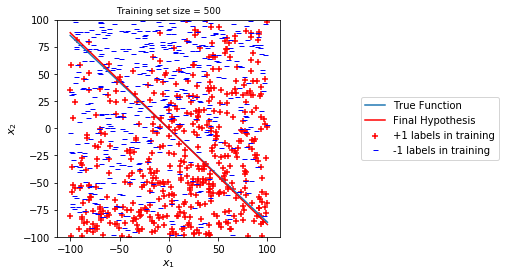

In [76]:
#### problem 1.4 (f)
lb, ub = -100, 100
N, dim = 1000, 10 
num_random_numbers, num_grid_points = 1000, 2000
coeff_lb, coeff_ub = -10, 10
eta = 1
maxit = 2000
use_adaline, randomize =False, False
run_perceptron_experiment(N, dim, lb, ub, num_random_numbers, num_grid_points,
                             coeff_lb, coeff_ub, eta, maxit, use_adaline, randomize)

(array([27., 28., 16., 11.,  6.,  3.,  2.,  3.,  1.,  3.]),
 array([  80. ,  271.9,  463.8,  655.7,  847.6, 1039.5, 1231.4, 1423.3,
        1615.2, 1807.1, 1999. ]),
 <a list of 10 Patch objects>)

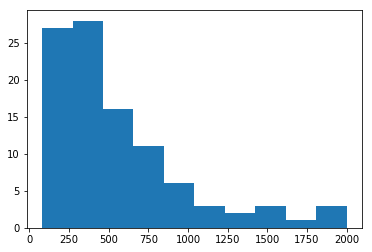

In [90]:
#### problem 1.4 (g)
lb, ub = -100, 100
N, dim = 1000, 10 
num_random_numbers, num_grid_points = 1000, 2000
coeff_lb, coeff_ub = -10, 10
eta = 1
maxit = 2000
use_adaline, randomize =False, True
show_plot = False
num_iterations = []
for it in range(100):
    #print('Working on experiment: ', it)
    num_it, _, _ = run_perceptron_experiment(N, dim, lb, ub, num_random_numbers, num_grid_points,
                                     coeff_lb, coeff_ub, eta, maxit, use_adaline, randomize,
                                      show_plot)
    num_iterations.append(num_it)
    
plt.hist(num_iterations)    

#### Problem 1.5

1. (e) When $\eta$ is large, with the same number of updates, the Adaline algorithm has difficulty finding a solution, and thus have lower accuracy. When $\eta$ is small, the algorithm can find a solution and have much better accuracy. 

final correctness:  34 . Total iteration:  15
final normalized w: [-0.07586802  0.59578129  1.        ]
True coeffs:  [ 9.98039216 16.41176471  1.        ]


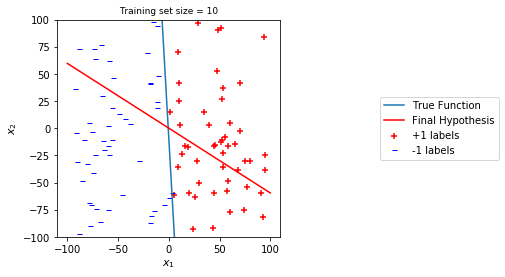

Eta =  100  Accuracy =  66.22
final correctness:  58 . Total iteration:  23
final normalized w: [ 0.21598485 -1.42468225  1.        ]
True coeffs:  [-1.11449016  0.27728086  1.        ]


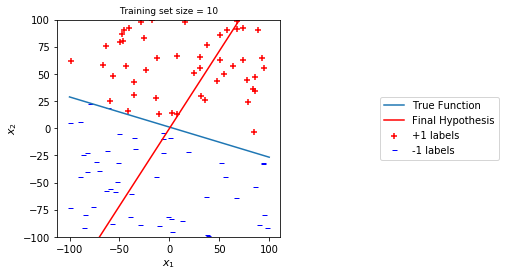

Eta =  1  Accuracy =  60.53
final correctness:  100 . Total iteration:  1
final normalized w: [0.09277263 4.63062835 1.        ]
True coeffs:  [1.25263158 6.32631579 1.        ]


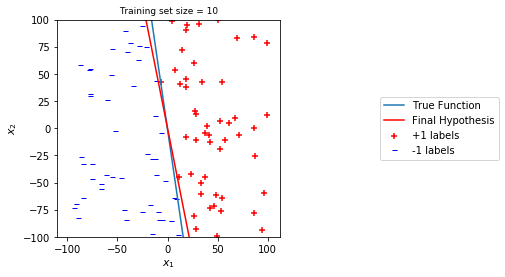

Eta =  0.01  Accuracy =  98.71
final correctness:  100 . Total iteration:  169
final normalized w: [-1.33738611 -4.60444596  1.        ]
True coeffs:  [-13.43902439  -5.63414634   1.        ]


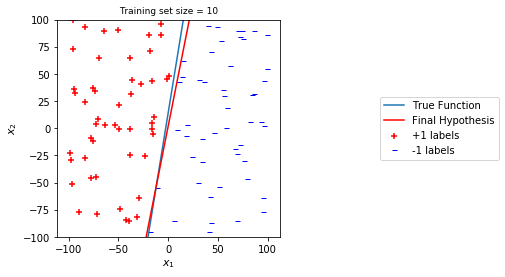

Eta =  0.0001  Accuracy =  98.78


In [120]:
#### problem 1.5 (a)-(d)
lb, ub = -100, 100
N, dim = 100, 2 
num_random_numbers, num_grid_points = 1000, 2000
coeff_lb, coeff_ub = -10, 10
maxit = 1000
use_adaline, randomize = True, True
show_plot = True

for eta in [100, 1, 0.01, 0.0001]:
    num_it, norm_g, test_df = run_perceptron_experiment(N, dim, lb, ub, num_random_numbers, num_grid_points,
                                     coeff_lb, coeff_ub, eta, maxit, use_adaline, randomize,
                                      show_plot, max_updates  = 1000, test_N=10000)

    xs = test_df[['x0', 'x1', 'x2']].values
    ys = test_df['y'].values
    accuracy = 0
    for x, y in zip(xs, ys):
        prod = np.dot(norm_g.T, x)*y
        if prod > 0:
            accuracy +=1
    print('Eta = ', eta, ' Accuracy = ', accuracy/100)

#### Problem 1.6

1. (a) $P(\nu=0) = (1-\mu)^{10}$, so 
  * $P(\nu = 0) =  0.5987369392383787$ when $\mu = 0.05$
  * $P(\nu = 0) =  0.0009765625$ when $\mu = 0.5$
  * $P(\nu = 0) =  1.0239999999999978e-07$ when $\mu = 0.8$


1. (b) We compute the probability that none of the 1000 samples have $\nu = 0$, i.e. all samples have $\nu \gt 0$. For a given sample, we have $P(\nu \gt 0) = 1-P(\nu = 0) = 1-(1-\mu)^{10}$.  
For all 1000 samples to have $\nu \gt 0$, the probability is 

$P(\cap_{i=1}^{1000} \nu_{i} \gt 0) = \prod_{i=1}^{1000}P(\nu_i \gt 0) = \prod_{i=1}^{1000}[1-(1-\mu)^{10}] =[1-(1-\mu)^{10}]^{1000}$

So the probability that at least one of the samples has $\nu = 0$ is: $1-P(\cap_{i=1}^{1000} \nu_{i} \gt 0) = 1-[1-(1-\mu)^{10}]^{1000}$

  * $P = 1$ when $\mu = 0.05$
  * $P = 0.623576201943276$ when $\mu = 0.5$
  * $P = 0.00010239476257623004$ when $\mu = 0.8$

1. (c) For 1000000 samples, we have the probability: $1-P(\cap_{i=1}^{1000000} \nu_{i} \gt 0) = 1-[1-(1-\mu)^{10}]^{1000000}$

  * $P = 1$ when $\mu = 0.05$
  * $P = 1$ when $\mu = 0.5$
  * $P = 0.09733159268316072$ when $\mu = 0.8$

According to Hoeffding inequality, for given tolerance, the upper bound decreases with the number of samples. The probability of the deviation between $\mu$ and $\nu'$ (proportion of red marbles in samples) becomes smaller and smaller. So $\nu'$ is closer to $\mu$.

#### Problem 1.7

1. (a) Suppose there are $m$ coins, we compute the probability that none of the coins have $\nu = 0$, i.e. all coins have $\nu \gt 0$. For a given coin, we have $P(\nu \gt 0) = 1-P(\nu = 0) = 1-P[0|N,\mu] = 1-(1-\mu)^N$.  
For all $m$ coins to have $\nu \gt 0$, the probability is 

$P(\cap_{i=1}^{m} \nu_{i} \gt 0) = \prod_{i=1}^{m}P(\nu_i \gt 0) = \prod_{i=1}^{m}[1-(1-\mu)^{N}] =[1-(1-\mu)^{N}]^{m}$

So the probability that at least one of the coins has $\nu = 0$ is: $1-P(\cap_{i=1}^{m} \nu_{i} \gt 0) = 1-[1-(1-\mu)^{N}]^{m}$

  * $P= 0.5987369392383787$ when $\mu = 0.05, m = 1$
  * $P= 1$ when $\mu = 0.05, m = 1000$
  * $P= 1$ when $\mu = 0.05, m = 1000000$
  
  * $P= 1.02400000034919e-07$ when $\mu = 0.8, m = 1$
  * $P= 0.00010239476257623004$ when $\mu = 0.8, m = 1000$
  * $P= 0.09733159268316072$ when $\mu = 0.8, m = 1000000$  

1. (b) TODO

For $N=6$ and 2 coins with $\mu = 0.5$, we have

\begin{align}
P[max_{i}|\nu_i - \mu| \gt \epsilon] &= 1 - P[max_{i}|\nu_i - \mu| \le \epsilon]\\
&= 1 - P[|\nu_1 - \mu| \le \epsilon\;and\;|\nu_2 - \mu| \le \epsilon\;\dots\;and\;|\nu_N - \mu| \le \epsilon]\\
&= 1 - \prod_{i=1}^{N}P[|\nu_i - \mu| \le \epsilon]\\
&= 1 - P[|\nu_1 - \mu| \le \epsilon]^N\\
\end{align}

#### Problem 1.8 

1. (a) Consider random variable $I(t\ge \alpha)$, which equals to $1$ when $t\ge \alpha$, else $0$. It's clear that for $\alpha \gt 0$ and $t$ a non-negative random variable, we have $\alpha I(t \ge \alpha) \le t$, take expectation on both sides, and since expectation is a monotonically increasing function here $(t \ge 0)$ , we have 
\begin{align}
E[\alpha I(t \ge \alpha)] &\le E[t]\\
\alpha E[I(t \ge \alpha)] &\le E[t]\\
E[I(t \ge \alpha)] &\le \frac{E[t]}{\alpha}\\
P[t \ge \alpha] &\le \frac{E[t]}{\alpha}\\
\end{align}

1. (b) Since $(u-\mu)^2 \ge 0$, according to problem (a) above, for any $\alpha \gt 0$, we have $P[(u - \mu)^2 \ge \alpha] \le \frac{E[(u-\mu)^2]}{\alpha} = \frac{\sigma^2}{\alpha}$.

1. (c) $u = \frac{1}{N}\sum_{n=1}^{N}$, this random variable has mean $\mu$ and variance $\frac{\sigma^2}{N}$. Take this into problem (b)'s inequation, we have $P[(u-\mu)^2 \ge \alpha] \le \frac{\sigma^2}{N\alpha}$.

This is the Chebyshev Inequality. Notice that the RHS goes down linearly in $N$, while the counterpart in Hoeffding's Inequality goes down exponentially. 

#### Problem 1.9

1. (a) Consider random variable $I(t\ge \alpha)$, which equals to $1$ when $t\ge \alpha$, else $0$. It's clear that $e^{st}$ is monotonically increasing in $t$.We have $e^{\alpha t} I(t \ge \alpha) \le e^{st}$, take expectation on both sides, and since expectation is a monotonically increasing function here $(e^{st} \ge 0)$ , we have 

$$
\begin{align}
E[e^{\alpha t} I(t \ge \alpha)] &\le E[e^{st}]\\
e^{\alpha t} E[I(t \ge \alpha)] &\le E[e^{st}]\\
E[I(t \ge \alpha)] &\le e^{-\alpha t}E[e^{st}]\\
P[t \ge \alpha] &\le e^{-\alpha t}T(s)\\
\end{align}
$$

1. (b) Choose $t = uN$, and use $N\alpha$ to replace $\alpha$, according the previous problem, we have

$$
\begin{align}
P[uN \ge N\alpha] &\le e^{-sN\alpha}E[e^{suN}]\\
P[u \ge \alpha] &\le e^{-sN\alpha}E[e^{s\sum_{n=1}^{N}u_n}]\\
P[u \ge \alpha] &\le e^{-sN\alpha}E[\prod_{n=1}^{N}e^{su_n}]\\
P[u \ge \alpha] &\le e^{-sN\alpha}\prod_{n=1}^{N}E[e^{su_n}]\\
P[u \ge \alpha] &\le e^{-sN\alpha}E[e^{su_n}]^N\\
P[u \ge \alpha] &\le \left(e^{-s\alpha}U(s)\right)^N\\
\end{align}
$$

1. (c) $U(s) = E(e^{su_n}) = P(u_n=0)e^0 + P(u_n=1)e^s = \frac{1}{2}(1+e^s)$, let's minimize $e^{-s\alpha}U(s)$ by taking its derivative w.r.t. $s$ and let it equal to $0$, we have

\begin{align}
-\alpha e^{-s\alpha}\frac{1}{2}(1+e^s) + e^{-s\alpha}\frac{1}{2}e^s &= 0\\
\end{align}

we conclude that $s = ln{\frac{\alpha}{1-\alpha}}$ since $0 \lt \alpha \lt 1$.

1. (d) It's easy to see that $E[u] = \frac{1}{2}$. Let $\alpha = E(u) + \epsilon = \frac{1}{2} + \epsilon$, then we have $P[u \ge E(u) + \epsilon] \le (e^{-s\alpha}U(s))^N$ from previous problem. Since this inequality holds for every $s \gt 0$, it also holds for $s = ln{\frac{\alpha}{1-\alpha}}$. Take this $s$ into the RHS of the inequality, we have

$$
\begin{align}
e^{-s\alpha}U(s) &= e^{-s\alpha} \frac{1}{2}(1+e^s)\\
&= \frac{1}{2} e^{-\alpha ln{\frac{\alpha}{1-\alpha}}} (1+e^ {ln{\frac{\alpha}{1-\alpha}}})\\
&= \frac{1}{2} \left(\frac{1-\alpha}{\alpha}\right)^{\alpha} (1+\frac{\alpha}{1-\alpha})\\
&= \frac{1}{2} \left(\frac{1-\alpha}{\alpha}\right)^{\alpha} \frac{1}{1-\alpha}\\
&= \frac{1}{2} \frac{(1-\alpha)^{\alpha -1}}{\alpha^{\alpha}}\\
&= \frac{1}{2} \frac{(\frac{1}{2}-\epsilon)^{\epsilon -\frac{1}{2}}}{(\frac{1}{2}+\epsilon)^{\frac{1}{2}+\epsilon}}\\
&= \frac{1}{2}(\frac{1}{2}-\epsilon)^{-(\frac{1}{2}-\epsilon)}(\frac{1}{2}+\epsilon)^{-(\frac{1}{2}+\epsilon)}\\
&= 2^{-\beta}\\
\end{align}
$$

where $\beta = 1 + (\frac{1}{2}+\epsilon)log_2{(\frac{1}{2}+\epsilon)}+ (\frac{1}{2}-\epsilon)log_2{(\frac{1}{2}-\epsilon)}$

This proves that $P[u \ge E(u) + \epsilon] \le 2^{-\beta N}$.

We now prove that $\beta \gt 0$. To prove that $\beta \gt 0$, we first prove that $\beta$ is mononically increasing, then we find its minimum at $\epsilon = 0$. 

Take derivative of $\beta$ with respect to $\epsilon$, we have 
\begin{align}
\frac{\partial{\beta}}{\partial{\epsilon}} &= log_2{(\frac{1}{2}+\epsilon)} + 1 - log_2{(\frac{1}{2}-\epsilon)} - 1\\
&= log_2{(\frac{1}{2}+\epsilon)} - log_2{(\frac{1}{2}-\epsilon)}\\
\end{align}

The derivative is always larger or equal to zero, so $\beta$ is mononically increasing function. It thus achieves minimum at left point, $\epsilon=0$, where $\beta=0$. 
So we have proved that $\beta \gt 0$, since $0 \lt \epsilon \lt \frac{1}{2}$. hence the bound is exponentially decreasing in $N$.

#### Problem 1.10

1. (a) $E_{off}(h,f)$ equals to the fraction of odd numbers between $N+1$ and $N+M$ in total $M$ numbers.

1. (b) For a function $f$ to generate $\mathcal{D}$ in a noiseless setting, it means $f(x_i)=y_i$ for $i=1,2,\dots, N$. They only have freedom to assign various values on the rest points in $\mathcal{X}$, i.e. $x_{N+1},\dots,x_{N+M}$. So there are total $2^M$ $f$ that can generate $\mathcal{D}$.

1. (c) Among those $f$ in(b), if they agree with a given $h$ on $M-k$ points, i.e. $E_{off}(h,f)=\frac{k}{M}$, then each of them need to choose $k$ points from $M$ $x_{N+1},\dots,x_{N+M}$ to match with $y$, and other $M-k$ points to mismatch with $y$.
This has ${M \choose k}$ combinations.

1. (d) The expectation is w.r.t. $f$. Given a hypothesis $h$, for an integer $k$ between $0$ and $M$, from previous problem (c), we know that there are ${M \choose k}$ number of functions $f$ that satisfy $E_{off}(h,f)=\frac{k}{M}$. So the probability to get $E_{off}(h,f)=\frac{k}{M}$ is $\frac{M \choose k }{2^M}$. So the expectation is $E_{f}[E_{off}(h,f)] = \frac{1}{2^M} \sum_{k=0}^{M} {M \choose k} \frac{k}{M}$.

1. (e) The above expectation in problem (d) depends on $M$ only, and doesn't depend on $h$ at all (each term in the expectation depends on the number of mismatches between $h$ and $f$, but they are consumed in the expectation). So for any two deterministic algorithms $A_1$ and $A_2$, the expectations will be the same.  

We thus proved that in a noiseless setting, for a fixed $\mathcal{D}$, if all possible $f$ are equally likely, any two deterministic algorithms are equivalent in terms of the expected off-training-set error. 

#### Problem 1.11

Let the risk to be $r_{1}$ when $y_n=1$ and $r_{-1}$ when $y_n = -1$. The in-sample error $E_{in} = \sum_{i=1}^{N} max\left( -h(x_i)y_i,0\right)r(y_i) = \sum_{i=1}^{N} max\left( -h(x_i)y_i,0\right) [max(y_i,0), max(-y_i,0)] \cdot [r_1, r_{-1}]^T $

#### Problem 1.12

1. (a) Take derivative of $E_{in}(h)$ w.r.t. $h$, and let it equal to $0$, we have

\begin{align}
\frac{\partial{E_{in}(h)}}{\partial{h}} &= \sum_{n=1}^{N}2(h-y_n) \\
h_{mean} &= \frac{1}{N} \sum_{n=1}^{N}y_n\\
\end{align}

1. (b) Take derivative of $E_{in}(h)$ w.r.t. $h$, and let it equal to $0$, we have

\begin{align}
\frac{\partial{E_{in}(h)}}{\partial{h}} &= \sum_{n=1}^{N}sign(h - y_n) \\
\end{align}

It's clear, that $h_{med}$ (which is any value for which half the data points are at most $h_{med}$ and half the data points are at least $h_{med}$) will make the derivative to zero, thus minimize the in-sample error.

1. (c) If $y_N$ is perturbed to $y_N + \epsilon$, where $\epsilon \to \infty$, we can see that $h_{mean}$ will increase a lot since $y_N$ contributes to its calculation, but $h_{med}$ can stay the same, because it only requires $h_{med} \lt y_N$.